In [1046]:
import numpy
from data.data_utils import load_dataset



In [1047]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.linalg import svd
from pdb import set_trace

# Q1 K-NN for Regression

In [1048]:
np.random.seed(42)

## Useful functions

In [1049]:
# Get RMSE
def RMSE(y, y_hat):
  return np.sqrt(np.mean(np.square(y-y_hat)))

In [1050]:
def knn_regressor(x_train, y_train, x_test, k = 1, metric = "minkowski_2") -> np.array:
    """
    Find the k-th closest data points along x axis and take the average of their y values.
    Do that for all testing data and return the predicted y values.
    """
    y_test = np.zeros((x_test.shape[0], 1))
    # print(y_test.shape)
    for i, x_test_i in enumerate(x_test):
        if metric == "minkowski_2":
          dist = np.sqrt(np.sum(np.square(x_train - x_test_i.reshape((1,-1))), axis = 1))
        elif metric == "minkowski_1":
          dist = np.sum(np.abs(x_train - x_test_i.reshape((1,-1))), axis = 1)
        else:
            pass
        i_nn = np.argpartition(dist, kth=k)[:k]
        # k=5: i_nn=[122 384  90 399  40] etc
        # compute the mean of these nearest neighbours
        y_test[i,0] = np.mean(y_train[i_nn, 0])
    # y_test: [[mean y for x_test_1], [mean y for x_test_2], [mean y for x_test_3]] ...
    return y_test

def knn_cross_validation(x, y, dataset, metrics, v = 5) -> np.array:
    """
    Cross validation to find the y_test,
    Return k_vals, best, fold_i[np.argmin(best)], k_merged_prediction
    k_vals : list of all k we tried
    best : list of lowest RMSE for each k values
    fold_i[np.argmin(best)] : the fold index with the lowest RMSE value
    k_merged_prediction : predictions merged from cross-validation for each k value
    """
    # Create shuffling indices for training data
    n = x.shape[0]

    # Initialize mrse returned array
    rmse = []
    # rmse[:] = np.nan
    # print(type(mrse))
    if dataset == "mauna_loa" and metrics == "minkowski_2": # plot the training data in the first figure
        plt.figure(figsize=(10,7))
        plt.plot(x.squeeze(), y.squeeze(), 'k', label='Exact', alpha=0.5)

    # Create random k value
    min_k = dict(rosenbrock=1,  pumadyn32nm=22, mauna_loa=1)  # specify minimum k value to consider in the search
    max_k = dict(rosenbrock=10, pumadyn32nm=26, mauna_loa=30) # specify maximum k value to consider in the search
    # Define a range of k
    k_vals = np.arange(min_k[dataset], max_k[dataset]+1, dtype=int)
    # print(k_vals)
    
    # print("predictions", predictions.shape)
    for k in k_vals:
        predictions = np.zeros(x.shape[0])
        # predictions[:] = np.nan
        val_err_in_fold = []
        # val_err_in_fold[:] = np.nan
        five_fold = np.array([0,1,2,3,4])
        idx_cv = np.ones(x.shape[0])
        idx_cv = np.arange(x.shape[0], dtype=int)
        idx_cv = np.random.permutation(idx_cv)
        idx_cv = np.array_split(idx_cv, 5)
        for i_split in range(v):
            train_fold = np.delete(five_fold, i_split)
            # print("train_fold", train_fold)
            split_train = np.concatenate([idx_cv[i] for i in train_fold])
            split_valid = idx_cv[i_split]
            # print("len:", len(split_train), len(split_valid))
            x_valid = x[split_valid]
            # print("split valid", len(split_valid))
            # print("y", y.shape)
            y_valid = y[split_valid]
            # print("split valid", split_valid)
            # print("split train", split_train)
            # print("x", x[split_train])
            predictions[split_valid] = knn_regressor(x_train=x[split_train], y_train=y[split_train], 
                                                        x_test=x_valid, k=k, metric=metrics).squeeze()
            val_err = RMSE(y=y_valid.squeeze(), y_hat=predictions[split_valid])
            val_err_in_fold.append(val_err)
        # print("k", k, val_err_in_fold)
        rmse.append(val_err_in_fold)
        if dataset == 'mauna_loa' and k in [2, 22] and metrics == "minkowski_2":
            plt.plot(x.squeeze(), predictions, label='k=%d validation prediction'%k)
            # plt.legend(loc=0)
            plt.xlabel("date")
            plt.ylabel("CO2")
            plt.legend(loc=0)
            plt.title("Mauna Loa Cross-validation predictions (Minkowski 2)")
    # print("mse", np.asarray(rmse))
    rmse = np.asarray(rmse)
    fold_i = rmse.argmin(axis=1)
    best = rmse.min(axis=1)
    # print("best",best)
    return k_vals, best, fold_i[np.argmin(best)]

## Mauna Loa

In [1051]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
# Merge splits
x = np.vstack([x_valid, x_train])
y = np.vstack([y_valid, y_train])

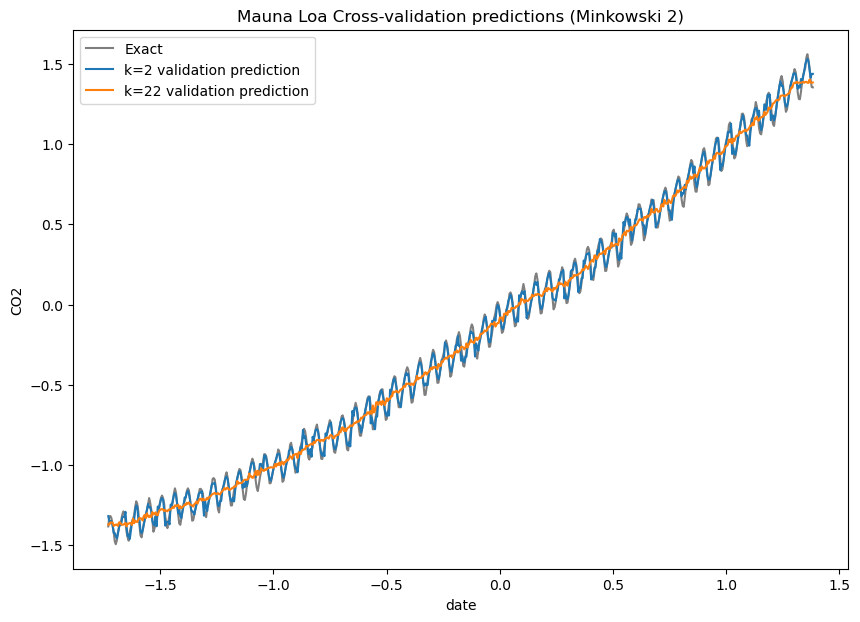

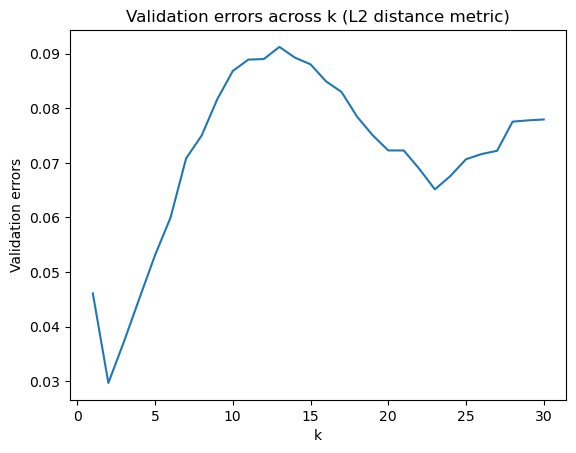

In [1052]:
k_vals, best2, fold_2 = knn_cross_validation(x, y, "mauna_loa", v = 5, metrics = "minkowski_2")

plt.figure()
plt.title('Validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.ylabel('Validation errors')
plt.plot(k_vals, best2)

# print(k_vals,best2,fold_2)


In [1053]:
# rmse = [[1,2,3],[4,5,6]]
# rmse_max = [max(r) for r in rmse]
# rmse_max

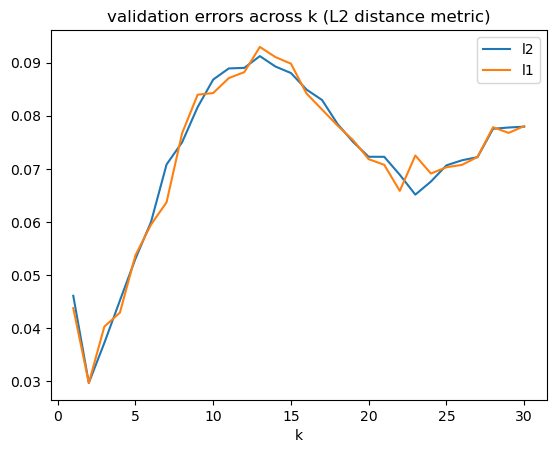

In [1054]:
_, best1, fold_1 = knn_cross_validation(x, y, "mauna_loa", v = 5, metrics = "minkowski_1")
# best = [ err * 30 ]
# Show validation errors for both metrics
plt.figure()
plt.title('validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.plot(k_vals, best2, label = "l2")
plt.plot(k_vals, best1, label = "l1")
plt.legend()
plt.show()

In [1055]:
idx1 = np.argmin(best1)
idx2 = np.argmin(best2)
p = np.argmin([best1[idx1], best2[idx2]]) + 1
if p == 2:
    k_best = idx2+1
    print("Metric Minkowski with p = %d at k = %d's %dth fold has the lowest validation error %f." %(p, k, fold_2+1, best2[idx2]))
else:
    k_best = idx1+1
    print("Metric Minkowski with p = %d at k = %d's %dth fold has the lowest validation error %f." %(p, k, fold_1+1, best1[idx1]))

# Find test error
def k_nn_test_error(x_train, y_train, x_test, y_test, k, metric) -> np.array:
    predictions = knn_regressor(x_train = x_train, y_train = y_train, 
                                x_test = x_test, k = k, metric = metric).squeeze()
            # print(predictions)
            # print("dim valid", y_valid.squeeze().shape)
            # print("dim pred", predictions.shape)
    test_err = RMSE(y=y_test.squeeze(), y_hat=predictions)
    
    return predictions, test_err
m_best = "minkowski_" + str(p)
predictions, test_err = k_nn_test_error(x, y, x_test, y_test, k = k_best, metric = m_best)
print("The test error for the best model is: %f" %(test_err))


Metric Minkowski with p = 1 at k = 2's 2th fold has the lowest validation error 0.029679.
The test error for the best model is: 0.440705


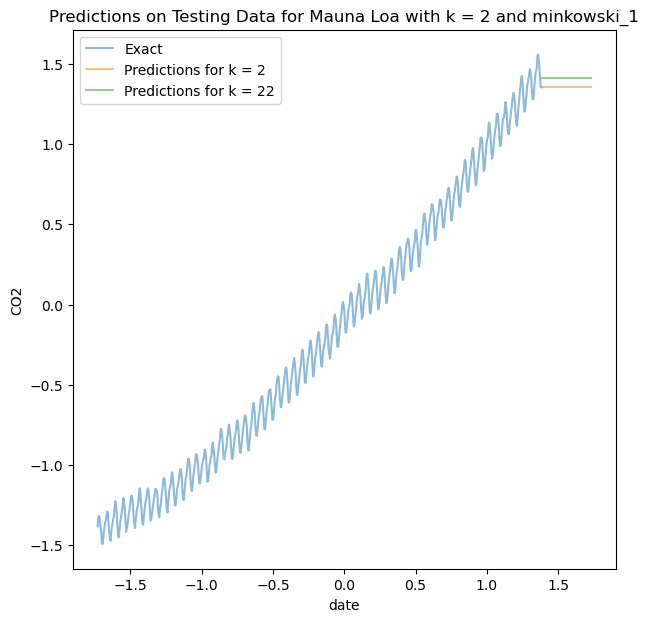

In [1056]:
# Plot Prediction Curves for several k values
y_test_pred_2 = knn_regressor(x, y, x_test, k = 2, metric = m_best)
y_test_pred_22 = knn_regressor(x, y, x_test, k = 22, metric = m_best)

plt.figure(figsize=(7,7))
plt.title('Predictions on Testing Data for Mauna Loa with selected k and %s'%(m_best))
plt.ylabel('CO2')
plt.xlabel('date')
plt.plot(x.squeeze(), y.squeeze(), label='Exact', alpha=0.5)
plt.plot(x_test.squeeze(), y_test_pred_2.squeeze(), label='Predictions for k = 2', alpha=0.5)
plt.plot(x_test.squeeze(), y_test_pred_22.squeeze(), label='Predictions for k = 22', alpha=0.5)
plt.legend()
plt.show()

In [1057]:
x_valid.shape

(145, 1)

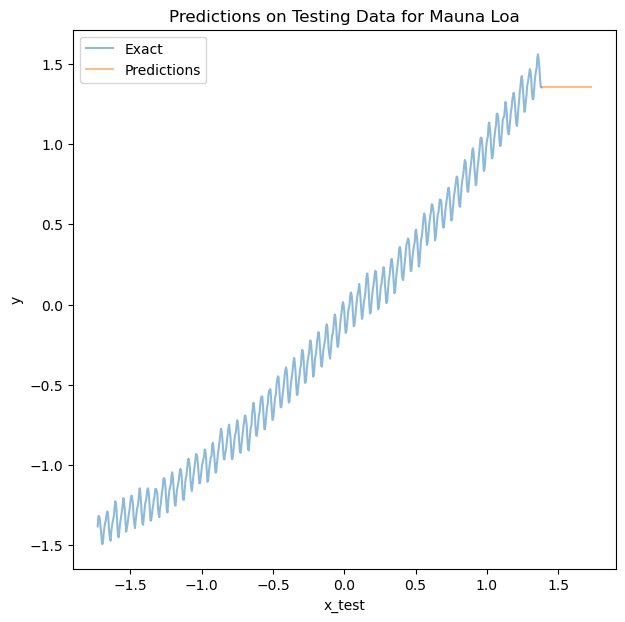

In [1058]:
# Visualize our data
plt.figure(figsize=(7,7))
plt.title('Predictions on Testing Data for Mauna Loa')
plt.ylabel('y')
plt.xlabel('x_test')
plt.plot(x.squeeze(), y.squeeze(), label='Exact', alpha=0.5)
plt.plot(x_test.squeeze(), predictions.squeeze(), label='Predictions', alpha=0.5)
plt.legend()
plt.show()

## Rosenbrock, n_train=1000, d=2

In [1059]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)


In [1060]:
# Merge splits
x = np.vstack([x_valid, x_train])
y = np.vstack([y_valid, y_train])

# # Visualize our data
# plt.figure(figsize=(3,3))
# plt.plot(x_train.squeeze(), y_train.squeeze(), 'k', label='Exact', alpha=0.5)

In [1061]:
_, best1, fold_1 = knn_cross_validation(x, y, x_test, "rosenbrock", v = 5, metrics = "minkowski_1")
_, best1, fold_1 = knn_cross_validation(x, y, x_test, "rosenbrock", v = 5, metrics = "minkowski_1")

TypeError: knn_cross_validation() got multiple values for argument 'metrics'

In [ ]:
plt.figure()
plt.title('validation errors across k (L2 distance metric)')
plt.xlabel('k')
plt.plot(k_vals, best2)
